# Test Benchmarking

This file is to test some benchmarking of the $\mathcal{O}(n^2)$ implementation of the t-SNE algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Customize matplotlib
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15

Read the data.

In [2]:
start = 200
stop = 4000
interval = 200

input_size = np.arange(start, stop+1, interval)
iters = np.loadtxt("../implementations/tsne_exact/benchmarking/20170502_100055@-O3 -march=native@iters.txt")
cycles = np.loadtxt("../implementations/tsne_exact/benchmarking/20170502_100055@-O3 -march=native@cycles.txt")
assert np.all(cycles[:,:-1].sum(axis=1) == cycles[:,-1])

Now compute the flops operations.

In [3]:
N = input_size.astype("float")
it = iters.astype("float")
D = 28 * 28
d = 2
T = 1000   # Number of iterations

count_measure=("add", "mult", "div", "exp", "log")

Define some auxiliar functions.

In [4]:
def sum_operations_by_measure(flops):
    flops_count = dict()
    #for measure in count_measure:
    #    flops_count[measure] = 
    
    for k, v in flops.items(): 
        for op, cycles in v.items():
            if op not in flops_count:
                flops_count[op] = cycles.copy()
            else:
                flops_count[op] += cycles.copy()
                
    return flops_count

def sum_operations(flops):
    flops_count = None
    for k, v in flops.items():
        if flops_count is None:
            flops_count = v.copy()
        else:
            flops_count += v.copy()
    return flops_count

def sum_operations_by_function(flops, function_list=("normalize", "compute_pairwise_affinity_perplexity",
                                                    "symmetrize_affinities", "early_exageration",
                                                    "compute_low_dimensional_affinities", 
                                                    "gradient_computation", "gradient_update", 
                                                    "normalize_2"), size=N.shape[0]):
    flops_count = np.zeros((size, len(function_list)), dtype="float")
    
    for i, func in enumerate(function_list):
        flops_count[:,i] += sum_operations(flops[func])
    return flops_count

In [5]:
flops = {
    "normalize": {
        "add": 2 * N * D,
        "div": D + N * D
    },
    "compute_pairwise_affinity_perplexity": {
        "compute_squared_euclidean_distance": {
            "add": D * N*(N-1)/2 * 2,
            "mult": D * N*(N-1)/2
        },
        "binary_search": {
            "add": it * (N + N + 1 + 1),
            "mult": it * (N + 2*N),
            "div": it * (1 + 1) + N * N,
            "exp": it * N,
            "log": it * (1 + 1)
        }
    },
    "symmetrize_affinities": {
        "add": N*(N-1)/2 + N*N,
        "div": N*N
    },
    "early_exageration": {
        "mult": 2 * N*N
    },
    "compute_low_dimensional_affinities": {
        "compute_squared_euclidean_distance": {
            "add": T * d * N*(N-1)/2 * 2,
            "mult": T * d * N*(N-1)/2
        },
        "compute": {
            "add": T * N * (N-1) * 2,
            "div": T * N * (N-1)
        }
    },
    "gradient_computation": {
        "add": T * N * (N-1) * (1 + 2*d),
        "mult": T * N * (N-1) * (1+d),
        "div": T * N * (N-1)
    },
    "gradient_update": {
        "add": T * (N*d + N * d * 2),
        "mult": T * N * d * 3
    },
    "normalize_2": {
        "add": T * 2 * N * d,
        "div": T * (d + N * d)
    }
}

# Reduce the previous dictionary to the main functions which cycles have been counted.
flops_by_function_measure = dict(flops)
flops_by_function_measure["compute_pairwise_affinity_perplexity"] = \
    sum_operations_by_measure(flops["compute_pairwise_affinity_perplexity"])
flops_by_function_measure["compute_low_dimensional_affinities"] = \
    sum_operations_by_measure(flops["compute_low_dimensional_affinities"])
flops_by_function = sum_operations_by_function(flops_by_function_measure)

Compute the total number of flops.

In [6]:
total_flops = sum_operations_by_measure(flops_by_function_measure)
total_flops = sum_operations(total_flops)
print(total_flops)

[  6.53031630e+08   2.61060579e+09   5.87256609e+09   1.04384369e+10
   1.63093538e+10   2.34840589e+10   3.19628743e+10   4.17469671e+10
   5.28326668e+10   6.52241145e+10   7.89198059e+10   9.39183471e+10
   1.10222639e+11   1.27830227e+11   1.46740056e+11   1.66953515e+11
   1.88475170e+11   2.11302676e+11   2.35429097e+11   2.60857509e+11]


In [7]:
performance_total = total_flops / cycles[:,-1]
print(performance_total)

[ 0.81977646  0.76691224  0.74510513  0.62273383  0.63857142  0.62996811
  0.65031247  0.56864274  0.6888695   0.68861971  0.69826779  0.67819239
  0.69846223  0.6781055   0.69416217  0.58302112  0.66205161  0.66252946
  0.65827322  0.62716381]


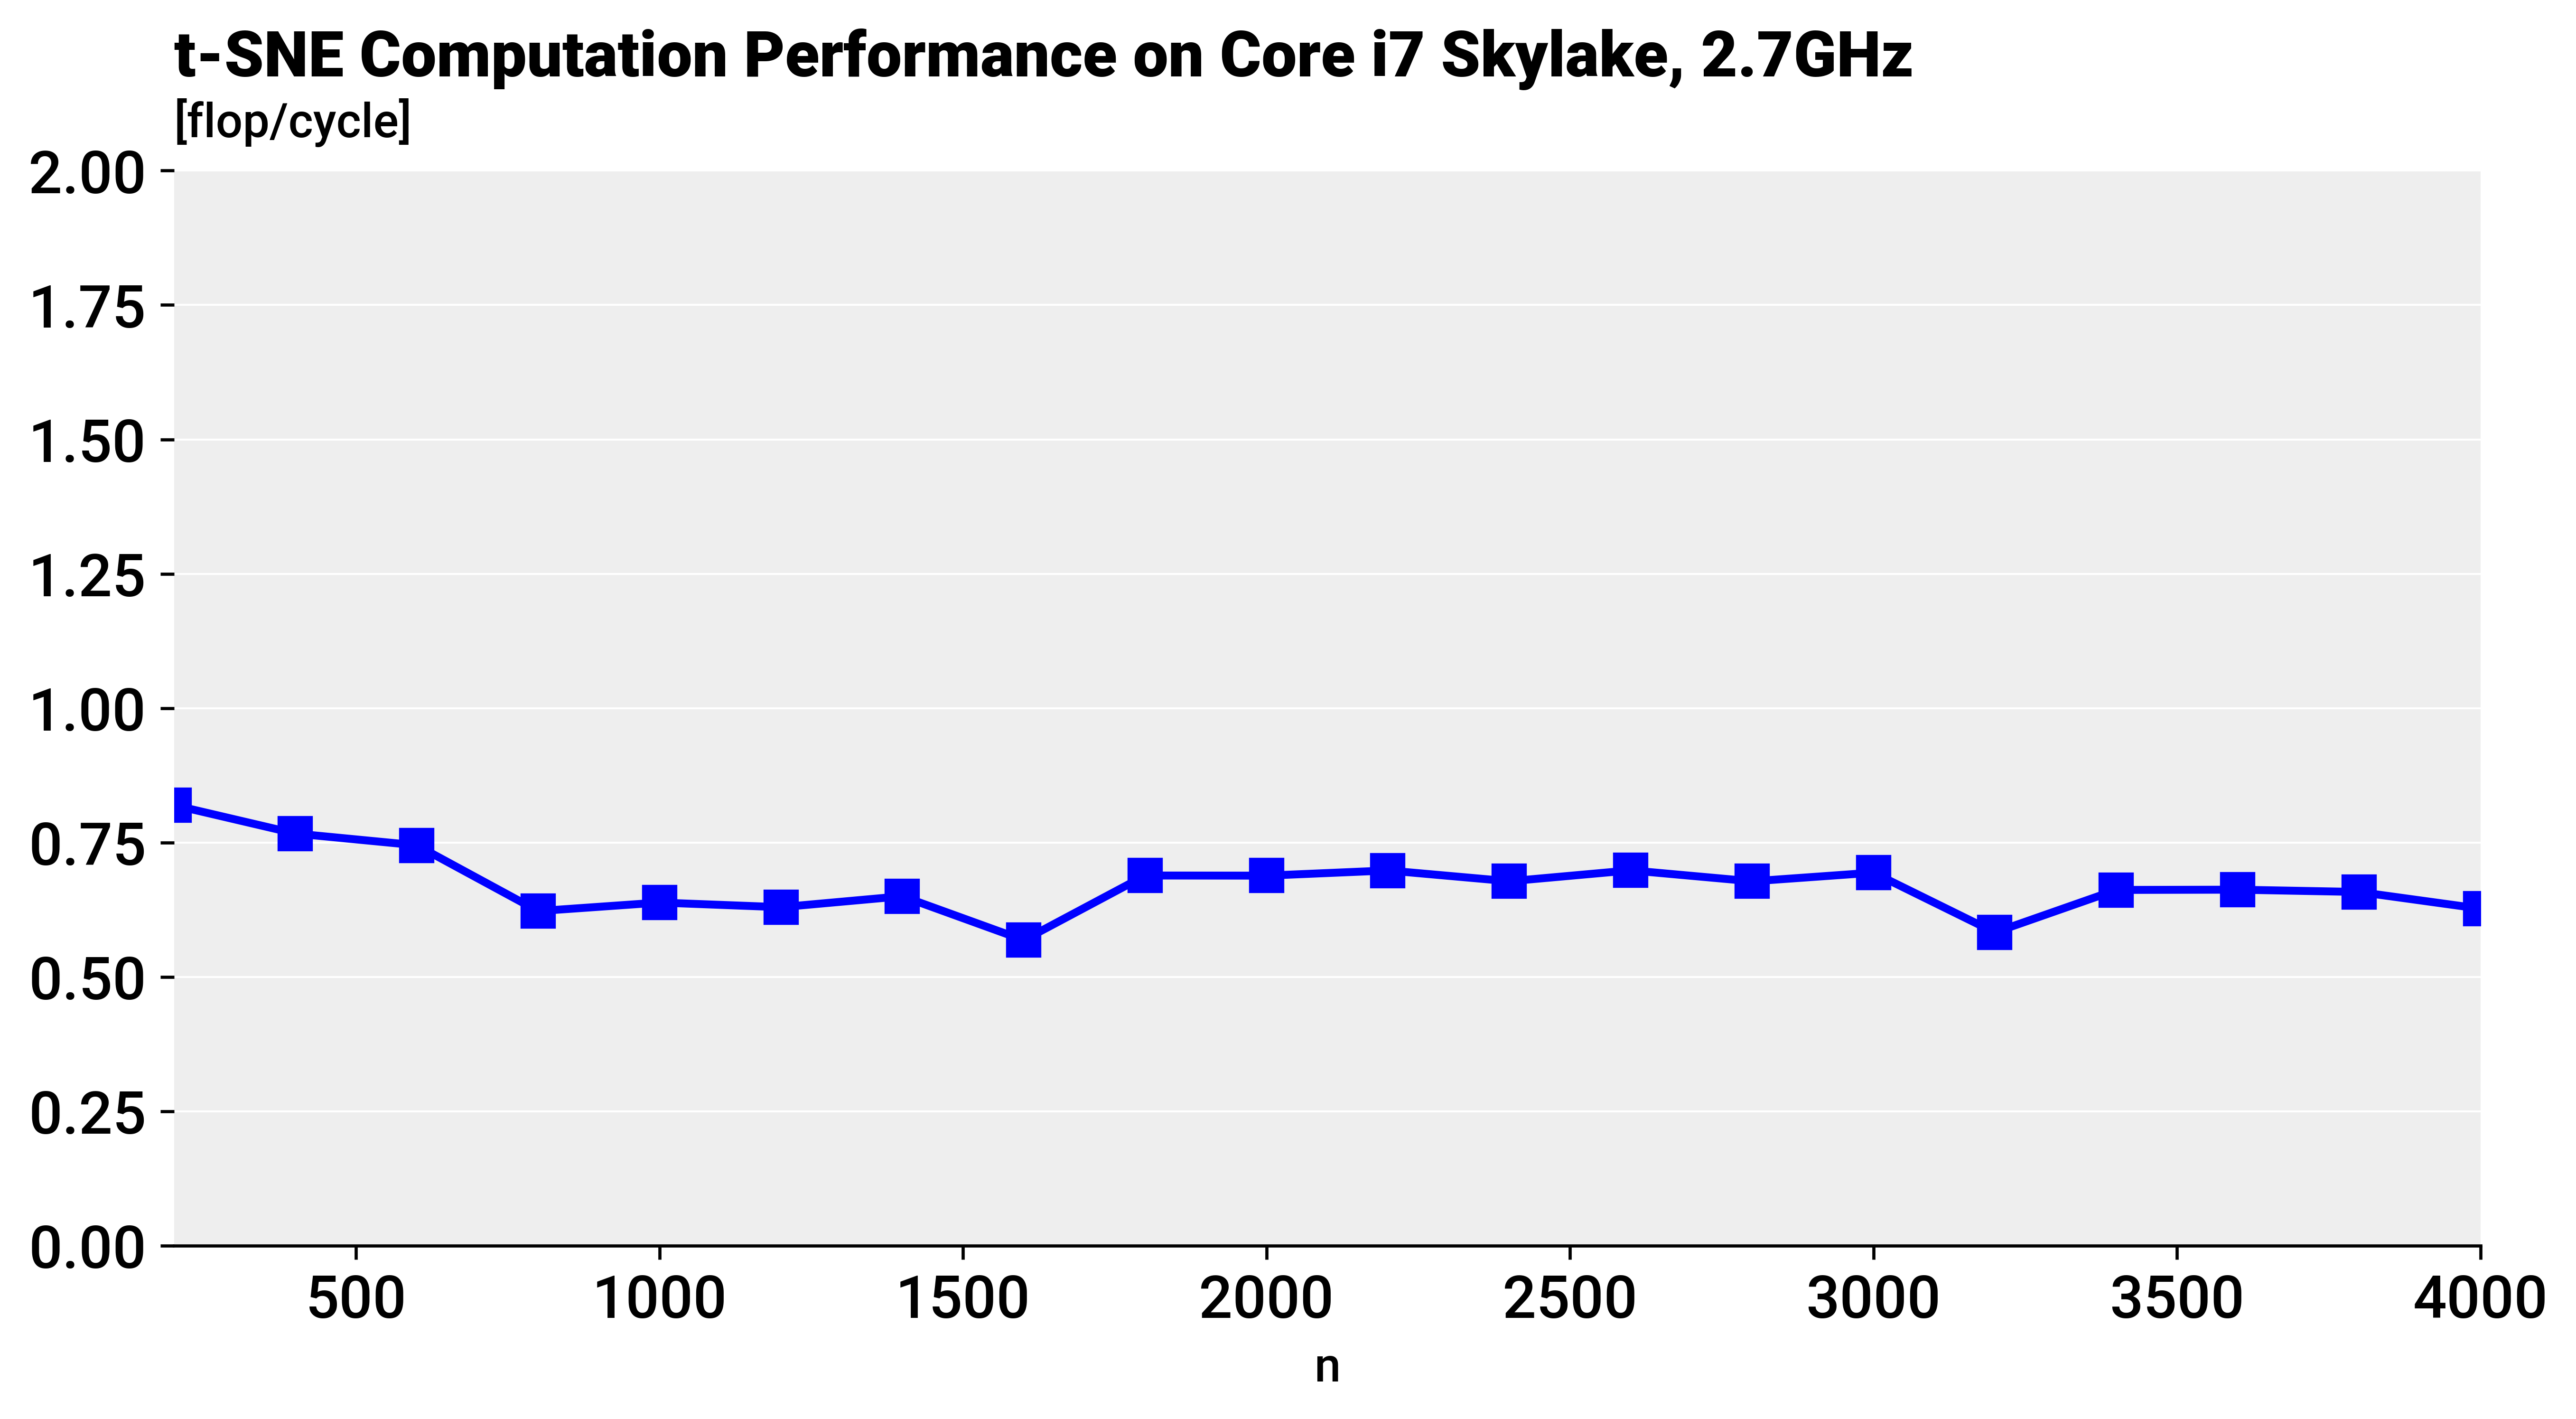

In [8]:
title = "t-SNE Computation Performance on Core i7 Skylake, 2.7GHz"
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"
ylabel = "flop/cycle"
color = ["gray", "blue", "red"]
ylim = 2
    
fig = plt.figure()
fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.88, left=0, right=1)

ax.plot(N, performance_total, linewidth=lw, c=color[1], marker=marker, markersize=markersize)
ax.set_ylim([0, ylim])

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)

# For runtime plots where on the yaxis there is an exponent, place the text on the axis title
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

exponent_text = ''
ax.set_title('[{}]{}'.format(ylabel, exponent_text), fontsize=labels_fontsize, 
             position=(0,1.0), ha='left', va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.show()

Now observe the performance by function.

In [ ]:
function_list=("normalize", "compute_pairwise_affinity_perplexity", "symmetrize_affinities", 
               "early_exageration", "compute_low_dimensional_affinities", "gradient_computation", 
               "gradient_update", "normalize_2")

performance_by_function = flops_by_function / cycles[:,:-1]

In [ ]:
title = "t-SNE Computation Performance on Core i7 Skylake, 2.7GHz"
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"
ylabel = "flop/cycle"
color = ["gray", "blue", "red"]
ylim = 2
    
fig = plt.figure()
fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.88, left=0, right=1)

for i, func in enumerate(function_list):
    ax.plot(N, performance_by_function[:,i], linewidth=lw, marker=marker, markersize=markersize, label=func)
#ax.plot(N, performance, linewidth=lw, c=color[1], marker=marker, markersize=markersize)
ax.set_ylim([0, ylim])
ax.legend(loc=1)

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)

# For runtime plots where on the yaxis there is an exponent, place the text on the axis title
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

exponent_text = ''
ax.set_title('[{}]{}'.format(ylabel, exponent_text), fontsize=labels_fontsize, 
             position=(0,1.0), ha='left', va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.show()